# NATURAL LANGUAGE PROCESSING PROJECT

De Almeida Matos Junior Roger, 2106919, roger.dealmeidamatosjunior@studenti.unipd.it

Capovilla Giulio, 2128832, giulio.capovilla@studenti.unipd.it

---------------
Spiegare NER

SPiegare zsl

Spiegare LLM used for zsl

Citare articolo ispirazionale

Parlare delle metodologie

Parlare dataset

---------------

## EXPERIMENTS

In [3]:
#LIBRARIES USED

from openai import OpenAI
import json
import re
from datasets import load_dataset
from dotenv import load_dotenv
import os
import random as rand
from collections import Counter

In [4]:
# DEEPSEEK LLM API CONNECTION
load_dotenv()

key = os.getenv("API_KEY")
client = OpenAI(api_key=key, base_url="https://api.deepseek.com")

In [5]:
# DATASET LOADING AND PREPARATION
dataset = load_dataset("ontonotes/conll2012_ontonotesv5", 'english_v4', trust_remote_code=True)
ner_dict = {
    "O": 0,
    "B-PERSON": 1,
    "I-PERSON": 2,
    "B-NORP": 3,
    "I-NORP": 4,
    "B-FAC": 5,
    "I-FAC": 6,
    "B-ORG": 7,
    "I-ORG": 8,
    "B-GPE": 9,
    "I-GPE": 10,
    "B-LOC": 11,
    "I-LOC": 12,
    "B-PRODUCT": 13,
    "I-PRODUCT": 14,
    "B-DATE": 15,
    "I-DATE": 16,
    "B-TIME": 17,
    "I-TIME": 18,
    "B-PERCENT": 19,
    "I-PERCENT": 20,
    "B-MONEY": 21,
    "I-MONEY": 22,
    "B-QUANTITY": 23,
    "I-QUANTITY": 24,
    "B-ORDINAL": 25,
    "I-ORDINAL": 26,
    "B-CARDINAL": 27,
    "I-CARDINAL": 28,
    "B-EVENT": 29,
    "I-EVENT": 30,
    "B-WORK_OF_ART": 31,
    "I-WORK_OF_ART": 32,
    "B-LAW": 33,
    "I-LAW": 34,
    "B-LANGUAGE": 35,
    "I-LANGUAGE": 36
}


In [6]:
# FUNCTION DEFINITIONS

def get_ner_label(value, ner_dict):
    for k, v in ner_dict.items():
        if v == value:
            return k
    return None

def send_prompt(prompt):
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            #{"role": "system", "content": "You are a helpful assistant"},
            {"role": "user", "content": prompt},
        ],
        stream=False
    )

    return response.choices[0].message.content

messages = []

def send_prompt_conversation(prompt):
    messages.append({"role": "user", "content": prompt})
    response = client.chat.completions.create(
        model="deepseek-chat", 
        messages=messages
    )
    reply = response.choices[0].message.content
    #print("Bot:", reply)
    messages.append({"role": "assistant", "content": reply})
    return reply

### VANILLA METHOD



In [30]:
def vanilla(data, label_set, file_name):
    for line in data:
        sentence = line["words"]
        prompt = f"Given the entity label set: {label_set}.\n \
        Based on the given entity label set, please recognize the named entities in the given text.\n \
        Return only a list of tuples with each token and its label without explenation. Your output must be in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else\n \
        Text: \n {" ".join(sentence)}"

        answer = send_prompt(prompt)
        with open(file_name, "a") as file:
            file.write(f"{answer}\n")


### CHAIN OF THOUGHT

In [31]:
def chain_of_thought(data, label_set, file_name):
    for line in data:
        sentence = line["words"]
        prompt = f"Given the entity label set: {label_set}.\n \
            Based on the given entity label set, please recognize the named entities in the given text and show your reasoning step by step for how you identify each entity.\n \
            You must conclude your reasoning by returning a list of tuples with each token and its label. \
            At the left and right of the list insert a '$' symbol. For example $[('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]$\n \
            You must return the list with the shown format only one time and no more. \
            Text: \n {" ".join(sentence)}"

        answer = send_prompt(prompt)
        with open(file_name, "a", encoding="utf-8") as file:
            file.write(f"{answer}\n")

### SELF VALIDATING

In [32]:
def self_validating(data, label_set, file_name):
    messages = []
    for line in data:
        sentence = line["words"]
        prompt = f"Given the entity label set: {label_set}.\n \
            Based on the given entity label set, please recognize the named entities in the given text.\n \
            Return only a list of tuples with each token and its label without explenation. Your output must be in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else\n \
            Text: \n {" ".join(sentence)}"

        messages.append({"role": "user", "content": prompt})
        response = client.chat.completions.create(
            model="deepseek-chat", 
            messages=messages
        )
        reply = response.choices[0].message.content
        messages.append({"role": "assistant", "content": reply})

        prompt_2 = f"Please carefully review your previous answer and correct any possible mistakes. \
        Keep the same output structure: a list of tuples in this format: \
        [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...] \
        Do not return any explanation or additional text.\n." 
          
        messages.append({"role": "user", "content": prompt})
        response = client.chat.completions.create(
            model="deepseek-chat", 
            messages=messages
        )
        reply = response.choices[0].message.content
        messages.append({"role": "assistant", "content": reply})

        with open(file_name, "a") as file:
            file.write(f"{messages[3]["content"]}\n")
        
        messages = []

### EVALUATION

In [68]:
import ast
import re
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_ner_error_piechart(errors):
    
    labels = list(errors.keys())
    sizes = list(errors.values())

    colors = plt.cm.Paired(range(len(labels)))

    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.axis('equal')
    plt.title('Error Types (Percentage)')
    plt.tight_layout()
    plt.show()


def parse_prediction(pred_str, ner_dict):
    pred_list = ast.literal_eval(pred_str)
    tokens = []
    label_ids = []
    for token, label in pred_list:
        tokens.append(token)
        label_ids.append(ner_dict.get(label, 0))
    return tokens, label_ids

def extract_mentions(labels):
    mentions = []
    start = None
    current_label = None
    for i, label in enumerate(labels):
        if label > 0:
            if start is None:
                start = i
                current_label = label
            elif label != current_label:
                mentions.append((start, i - 1, current_label))
                start = i
                current_label = label
        else:
            if start is not None:
                mentions.append((start, i - 1, current_label))
                start = None
                current_label = None
    if start is not None:
        mentions.append((start, len(labels) - 1, current_label))
    return mentions

def analyze_ner_errors(y_true, y_pred, ner_dict):
    id2label = {v: k for k, v in ner_dict.items()}
    error_counts = defaultdict(int)
    for true_labels, pred_labels in zip(y_true, y_pred):
        gold = extract_mentions(true_labels)
        pred = extract_mentions(pred_labels)

        matched_gold = set()
        matched_pred = set()

        for i, (gs, ge, glab) in enumerate(gold):
            for j, (ps, pe, plab) in enumerate(pred):
                if (gs == ps and ge == pe):
                    if glab != plab:
                        error_counts["Wrong Type"] += 1
                    matched_gold.add(i)
                    matched_pred.add(j)
                    break
            else:
                continue

        for i, (gs, ge, glab) in enumerate(gold):
            if i in matched_gold:
                continue
            matched = False
            for j, (ps, pe, plab) in enumerate(pred):
                if j in matched_pred:
                    continue
                if ps >= gs and pe <= ge:
                    error_counts["Contained by Gold"] += 1
                    matched_pred.add(j)
                    matched = True
                    break
                elif ps <= gs and pe >= ge:
                    error_counts["Contain Gold"] += 1
                    matched_pred.add(j)
                    matched = True
                    break
                elif (ps <= ge and pe >= gs):
                    error_counts["Overlap with Gold"] += 1
                    matched_pred.add(j)
                    matched = True
                    break
            if not matched:
                error_counts["Omitted Mentions"] += 1


        for j, (ps, pe, plab) in enumerate(pred):
            if j in matched_pred:
                continue
            error_counts["Completely-O"] += 1
            if plab not in set(label for _, _, label in gold):
                error_counts["OOD Mentions"] += 1

    return error_counts

def f1Score(file_path, sentences, dict=ner_dict):
    with open(file_path, 'r') as f:
        content = f.read()
    
    predictions = re.findall(r'(\[.*?\])', content, re.DOTALL)
    y_pred = []
    y_true = [sentences[i]["named_entities"] for i in range(len(predictions))]

    for i, pred in enumerate(predictions):
        pred_tokens, pred_labels = parse_prediction(pred.strip(), dict)
        true_tokens = sentences[i]["words"]
        true_labels = sentences[i]["named_entities"]

        aligned_preds = []
        pred_idx = 0

        if len(pred_labels) != len(true_labels):
            for true_token in true_tokens:
                if pred_idx < len(pred_tokens) and pred_tokens[pred_idx] == true_token:
                    aligned_preds.append(pred_labels[pred_idx])
                    pred_idx += 1
                else:
                    aligned_preds.append(-1)
        else:
            aligned_preds = pred_labels[:]
    
        y_pred.append(aligned_preds)

    flat_true = [label for seq in y_true for label in seq]
    flat_pred = [label for seq in y_pred for label in seq]
    
    precision = precision_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)
    recall = recall_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)
    f1 = f1_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    errors = analyze_ner_errors(y_true, y_pred, dict)
    plot_ner_error_piechart(errors)

    return f1

def f1Score_dollar(file_path, sentences, dict=ner_dict):
    with open(file_path, 'r') as f:
        content = f.read()
    
    predictions = re.findall(r'\$(\[.*?\])\$', content, re.DOTALL)
    y_pred = []
    y_true = [sentences[i]["named_entities"] for i in range(len(predictions))]

    for i, pred in enumerate(predictions):
        pred_tokens, pred_labels = parse_prediction(pred.strip(), dict)
        true_tokens = sentences[i]["words"]
        true_labels = sentences[i]["named_entities"]

        aligned_preds = []
        pred_idx = 0

        if len(pred_labels) != len(true_labels):
            for true_token in true_tokens:
                if pred_idx < len(pred_tokens) and pred_tokens[pred_idx] == true_token:
                    aligned_preds.append(pred_labels[pred_idx])
                    pred_idx += 1
                else:
                    aligned_preds.append(-1)
        else:
            aligned_preds = pred_labels[:]
    
        y_pred.append(aligned_preds)

    flat_true = [label for seq in y_true for label in seq]
    flat_pred = [label for seq in y_pred for label in seq]
    
    precision = precision_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)
    recall = recall_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)
    f1 = f1_score(flat_true, flat_pred, labels=list(dict.values()), average='micro', zero_division=0)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}\n\n")

    errors = analyze_ner_errors(y_true, y_pred, dict)
    plot_ner_error_piechart(errors)
    
    return f1

### TEST 


In [69]:
data = dataset["test"][0]["sentences"][0:100]
label_set = list(ner_dict.keys())

#vanilla(data, label_set, "vanilla_test.txt")
#chain_of_thought(data, label_set, "chain_of_thought_test.txt")
#self_validating(data, label_set, "self_validating_test.txt")


Vanilla NER F1 Score:
Precision: 0.9388
Recall:    0.9382
F1 Score:  0.9385


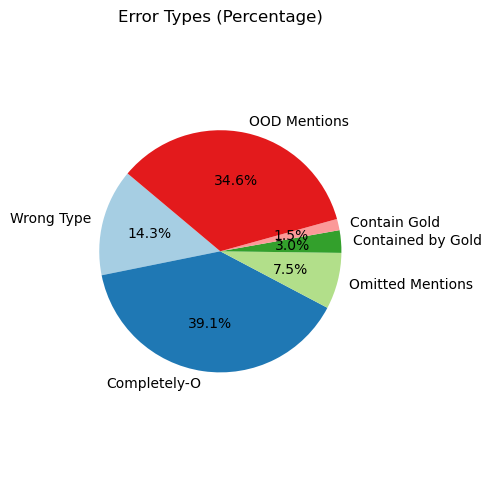


Chain-Of-Thought NER F1 Score:
Precision: 0.9452
Recall:    0.9434
F1 Score:  0.9443




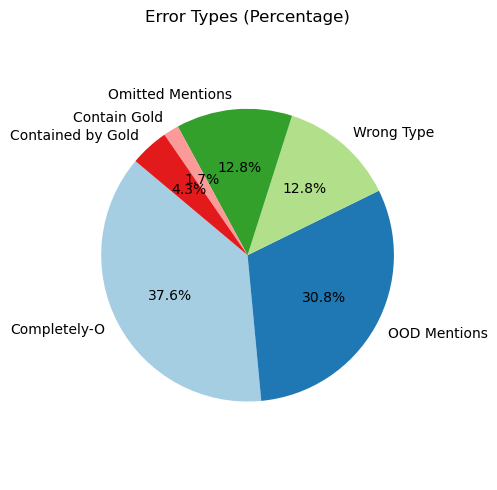


Self Validating NER F1 Score:
Precision: 0.9362
Recall:    0.9355
F1 Score:  0.9359


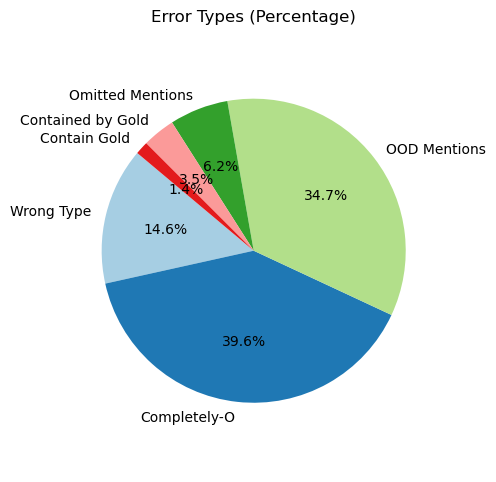

0.9358515141647672

In [70]:
data = dataset["test"][0]["sentences"]

print("\nVanilla NER F1 Score:")
f1Score("vanilla_test.txt", data, ner_dict)

print("\nChain-Of-Thought NER F1 Score:")
f1Score_dollar("chain_of_thought_test.txt", data, ner_dict)

print("\nSelf Validating NER F1 Score:")
f1Score("self_validating_test.txt", data, ner_dict)

### DISCUSSION OF THE RESULTS

----------

Spiegare perche cot funziona e altri no

Spiegare perche secondo noi gli altri metodi non hanno funzionato


----------

## DISCARDED METHODS

In [26]:
# Role play method

def role_play(data, label_set, file_name):
    for line in data:
        sentence = line["words"]
        prompt = f"You are a linguist expert professor. \
            You have a PHD and a post-doc in name entity recognition and you have been working with this in the past 20 years.\
            You are the best in the world at this task. You are creating a new NER dataset and you are labeling some sentences tokens.\
            Based on the given entity label set: {label_set}, \
            you are going to recognize the named entities in the given sentence.\n \
            You are going to return only a list of tuples with each token and its label without explenation. Your output must be in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else\n \
            Sentence: \n {" ".join(sentence)}"

        answer = send_prompt(prompt)
        with open(file_name, "a", encoding="utf-8") as file:
            file.write(f"{answer}\n")



# Role play and chain of thought method

def chain_of_thought_plus_role_play(data, label_set):
    for line in data:    
        sentence = line["words"]
        prompt = f"You are a linguist expert professor. \
            You have a PHD and a post-doc in name entity recognition and you have been working with this in the past 20 years.\
            You are the best in the world at this task. You are creating a new NER dataset and you are labeling some sentences tokens.\
            Based on the given entity label set: {label_set}, \
            you are going to recognize the named entities in the given sentence and show your reasoning step by step for how you identify each entity.\n \
            You must conclude your reasoning by returning a list of tuples with each token and its label. \
            At the left and right of the list insert a '$' symbol. For example $[('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]$\n \
            You must return the list with the shown format only one time and not more. \
            The sentence is: \n {" ".join(sentence)}"

        answer = send_prompt(prompt)
        print(prompt)
        with open(label_set, "a", encoding="utf-8") as file:
            file.write(f"{answer}\n")



# Double input method

def divided_inputs(data, label_set, file_name):
    for line in data:
        sentence = line["words"]
        prompt = f"Take as input the sentence: \n  {' '.join(sentence)}  \n \
            --Break it down into its tokens and return them as a list. \
            The tokens will be used for a named entity recognition task.\n"

        send_prompt_conversation(prompt)

        prompt_2 = f"Given the entity label set: {label_set},\n \
                    based on the tokens you found in the previous step, \
                    please recognize the named entities in the given text and return a list of tuples with each token and its label. \
                    Return only the list in the format: [('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]  \
                    Do not return any explanation or additional text.\n."
        
        send_prompt_conversation(prompt_2)

        with open(file_name, "a") as file:
            file.write(f"{messages[3]["content"]}\n")
        
        messages = []



# Threat model method

def threat(data, label_set, file_name):
    for line in data:
        sentence = line["words"]
        prompt = f"Given the entity label set: {label_set}.\n \
        Based on the given entity label set, please recognize the named entities in the given text.\n \
        Return only a list of tuples with each token and its label without explenation. Your output must be in the format: [('\"','O'),('In','O'), ('America','I-LOC'), ('is','O'), ('cold','O'), ...]; nothing else\n \
        Also, if you fail to identify all entities correctly, I will have to exchange you for another LLM and not use your help ever again. \
        Text: {" ".join(sentence)}"

        answer = send_prompt(prompt)
        with open(file_name, "a") as file:
            file.write(f"{answer}\n")



# Chain of thought plus decomposition method

def align_spans_to_bio(tokens, spans_list, ner_dict):

    bio_labels_str = ["O"] * len(tokens)
    
    for span_text, span_label in spans_list:

        span_tokens = span_text.split(" ")
        n = len(span_tokens)
        
        for i in range(len(tokens) - n + 1):
            if tokens[i:i+n] == span_tokens:

                bio_labels_str[i] = f"B-{span_label}"
                for j in range(1, n):
                    bio_labels_str[i+j] = f"I-{span_label}"
                break

    bio_ints = [ ner_dict.get(lbl, ner_dict["O"]) for lbl in bio_labels_str ]
    return bio_ints


def COT_decomposition(data, ner_dict):
    for line in data:
        sentence = line["words"]
        text = " ".join(sentence)
        labels = [ label for label in ner_dict.keys() if label.startswith("B-") ]
        label_names = [ lbl.split("-", 1)[1] for lbl in labels ]
        merged_tags_str = ["O"] * len(sentence)

        for label_name in label_names:
        
            prompt = f"""

                You are a zero‐shot NER system with chain‐of‐thought reasoning.
                Your task: extract all spans of type "{label_name}" from the text below.

                Think step by step:
                    1. First, look at each token (and consecutive tokens) to see if they look like a proper name for "{label_name}".
                    2. If you’re unsure whether a multi‐word chunk belongs to "{label_name}", explain briefly your logic.
                    3. After thinking, return a list of tuples:  
                    [("span1_token1 span1_token2 …", "{label_name}"), ...]  
                    Example: [("New York City", "LOC"), ("Paris", "LOC")].  
                    Do not include any token‐level B- ou I- tags here, only text spans + type.

                Rules:
                    - List only spans that appear exactly in the text (case‐sensitive, white‐space sensitive, punctuation).  
                    - Do not invent any span not present in the text.  
                    - If an entity has multiple tokens (ex.: “New York City”), return them all together.
                    - Do not add any extra commentary outside the list of tuples. Format exactly as [(…), …].

                Text: {text}

                Return your reasoning steps followed by exactly one line with the list of spans (nothing else).
            
            """

            answer = send_prompt_conversation(prompt)
        
            m = re.search(r"\[.*\]", answer, re.DOTALL)
            spans_list = []
            if m:
                spans_list = ast.literal_eval(m.group(0))
        
            bio_ints_for_label = align_spans_to_bio(sentence, spans_list, ner_dict)
        
            bio_labels_str_for_label = [
                list(ner_dict.keys())[list(ner_dict.values()).index(idx)] 
                for idx in bio_ints_for_label
            ]
        
            for i, lbl in enumerate(bio_labels_str_for_label):
                    if lbl != "O":
                        merged_tags_str[i] = lbl

        #merged_ints = [ ner_dict.get(tag, ner_dict["O"]) for tag in merged_tags_str ]
            
        output_pairs = [(sentence[i], merged_tags_str[i]) for i in range(len(sentence))]
        with open("decomp_cot_results_nd.txt", "a", encoding="utf8") as file:
            file.write(f"{output_pairs}\n")
        
        messages = []